## Importing all the necessary Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn_extra.cluster import KMedoids
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import pickle

## Reading the dataset

In [3]:
news_data = pd.read_table('./news_data.tsv', delimiter='\t')

In [4]:
news_data

,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10235,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10236,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10237,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...


## Dropping all the un-necessary columns

In [6]:
news_data.drop(columns=['2635.json', 'abortion', 'dwayne-bohac', 'State representative', 'Texas', 'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer'], inplace=True)

KeyError: "['2635.json', 'abortion', 'dwayne-bohac', 'State representative', 'Texas', 'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer'] not found in axis"

In [7]:
news_data.head()

,false,Says the Annies List political group supports third-trimester abortions on demand.
0,half-true,When did the decline of coal start? It started...
1,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
2,false,Health care reform legislation is likely to ma...
3,half-true,The economic turnaround started at the end of ...
4,true,The Chicago Bears have had more starting quart...


In [8]:
news_data.columns = ['label', 'news_text']

In [9]:
news_data.head()

,label,news_text
0,half-true,When did the decline of coal start? It started...
1,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
2,false,Health care reform legislation is likely to ma...
3,half-true,The economic turnaround started at the end of ...
4,true,The Chicago Bears have had more starting quart...


In [10]:
news_data.shape

(10239, 2)

## Checking for null values in the dataset

In [11]:
news_data.isnull().sum()

label        0
news_text    0
dtype: int64

## Counting the total number of labels present in the dataset

In [12]:
each_label_count = news_data['label'].value_counts()

In [13]:
each_label_count

label
half-true      2114
false          1994
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

Since the results show that our dataset is imbalanced, 
we need to create a balanced dataset, to get quality results at the end.

## Creating a balanced dataset of 204 datapoints in total

Filtering: Start by filtering the data first each class and saving them in a variable

In [14]:
news_data_half_true_only = news_data[news_data['label'] == 'half-true']
news_data_false_only = news_data[news_data['label'] == 'false']
news_data_mostly_true_only = news_data[news_data['label'] == 'mostly-true']
news_data_true_only = news_data[news_data['label'] == 'true']
news_data_barely_true_only = news_data[news_data['label'] == 'barely-true']
news_data_pants_fire_only = news_data[news_data['label'] == 'pants-fire']

Next, take 34 data point from each class, where we will have 204 in total.
In this case, we guarantee that our dataset is balanced.

In [15]:
news_data_half_true_only_sample = news_data_half_true_only[0:34]
news_data_false_only_sample = news_data_false_only[0:34]
news_data_mostly_true_only_sample = news_data_mostly_true_only[0:34]
news_data_true_only_sample = news_data_true_only[0:34]
news_data_barely_true_only_sample = news_data_barely_true_only[0:34]
news_data_pants_fire_only_sample = news_data_pants_fire_only[0:34]

now concatenate the new dataset with the balanced data points.
In order to concatenate a pandas dataframe, we use the built in function with pandas
pd.concat([here we pass the dataframes.])

In [16]:
new_news_dataset = pd.concat([news_data_half_true_only_sample, news_data_false_only_sample, news_data_mostly_true_only_sample, news_data_true_only_sample, news_data_barely_true_only_sample, news_data_pants_fire_only_sample], axis=0)

In [17]:
new_news_dataset.head()

,label,news_text
0,half-true,When did the decline of coal start? It started...
3,half-true,The economic turnaround started at the end of ...
6,half-true,I'm the only person on this stage who has work...
7,half-true,"However, it took $19.5 million in Oregon Lotte..."
10,half-true,"Since 2000, nearly 12 million Americans have s..."


In [18]:
new_news_dataset.shape

(204, 2)

## Preprocessing all the news texts

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/larawehbe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/larawehbe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
ps = PorterStemmer()

In [23]:
def preprocess_text(text):

  text = text.lower() 

  text = nltk.word_tokenize(text)

  word_arr = []

  for i in text:
    if i.isalnum():
      word_arr.append(i)

  text = word_arr[:]

  word_arr.clear()

  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      word_arr.append(i)

  text = word_arr[:]

  word_arr.clear()

  for i in text:
    word_arr.append(ps.stem(i))

  return " ".join(word_arr)

## Creating a new column in the dataset and inserting all the pre-proccessed texts inside it

In [24]:
new_news_dataset['preprocessed_news_text'] = new_news_dataset['news_text'].apply(preprocess_text)

In [25]:
new_news_dataset.head()

,label,news_text,preprocessed_news_text
0,half-true,When did the decline of coal start? It started...,declin coal start start natur ga took start be...
3,half-true,The economic turnaround started at the end of ...,econom turnaround start end term
6,half-true,I'm the only person on this stage who has work...,person stage work activ last year pass along r...
7,half-true,"However, it took $19.5 million in Oregon Lotte...",howev took million oregon lotteri fund port ne...
10,half-true,"Since 2000, nearly 12 million Americans have s...",sinc 2000 nearli 12 million american slip midd...


## Dropping the plain un-proccessed 'news_text' and the 'label' column

In [26]:
new_news_dataset.drop(columns=['news_text', 'label'], inplace=True)

In [27]:
new_news_dataset.head()

,preprocessed_news_text
0,declin coal start start natur ga took start be...
3,econom turnaround start end term
6,person stage work activ last year pass along r...
7,howev took million oregon lotteri fund port ne...
10,sinc 2000 nearli 12 million american slip midd...


### Important question goes here:
Can we pass text data, like the one in preprocessed news text, to the model ? 

Of course not!
We need to convert them to numerical data

#### ENTER: TfIDF

## Initializing TfidfVectorizer

In [28]:
vectorizer = TfidfVectorizer()

## Vectorizing all the pre-proccessed news texts

In [29]:
X = vectorizer.fit_transform(new_news_dataset['preprocessed_news_text']).toarray()

## Applying Principal Component Analysis(PCA) on the vectorized text to reduce it from high dimension to low dimension

In [30]:
pca = PCA(n_components=2, random_state=42)

In [31]:
X = pca.fit_transform(X)

## Implementing k-means algorithm and finding the optimal number of clusters for k-means algorithm 

In [35]:
wcss = []

for i in range(1, 11):

  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)

  kmeans.fit(X)

  wcss.append(kmeans.inertia_)

In [30]:
wcss

[5.213262416759263,
 3.480173567965202,
 2.0397436362091304,
 1.561084035474699,
 1.2661923890496474,
 1.0048428509859741,
 0.8756050402702884,
 0.7543980346494221,
 0.6596261435684572,
 0.5657216613471671]

## Plotting the elbow point graph of the k-means algorithm

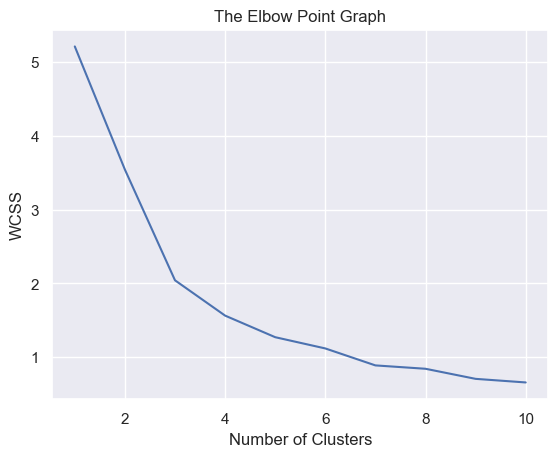

In [36]:
sns.set()

plt.plot(range(1, 11), wcss)

plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.show()

### In this elbow graph, we can see that after n_clusters=6, the graph is getting stabilized. Therefore, the optimal number of clusters for k-means is 6

## Training the model with the optimal number of clusters found in the elbow point graph

In [37]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)

In [38]:
kmeans.fit_predict(X)

array([5, 4, 1, 4, 1, 0, 0, 2, 4, 2, 0, 4, 0, 1, 4, 4, 5, 5, 3, 5, 4, 0,
       4, 2, 3, 2, 5, 4, 4, 5, 5, 3, 1, 5, 2, 4, 4, 4, 2, 5, 2, 4, 5, 2,
       5, 0, 4, 2, 2, 2, 1, 4, 1, 4, 4, 2, 1, 5, 4, 4, 1, 3, 2, 4, 4, 1,
       4, 4, 4, 4, 1, 4, 1, 1, 1, 4, 0, 0, 0, 0, 4, 1, 4, 1, 2, 2, 4, 4,
       4, 5, 1, 4, 1, 5, 4, 1, 0, 2, 1, 4, 1, 4, 1, 4, 2, 4, 1, 1, 5, 4,
       3, 4, 5, 5, 0, 2, 4, 4, 1, 1, 0, 4, 3, 2, 4, 2, 4, 4, 4, 1, 1, 2,
       4, 0, 4, 2, 1, 4, 4, 2, 1, 2, 1, 4, 4, 4, 4, 3, 2, 1, 5, 2, 1, 3,
       4, 0, 2, 2, 4, 3, 5, 2, 0, 1, 2, 4, 4, 5, 2, 2, 4, 4, 2, 4, 5, 4,
       3, 2, 5, 5, 5, 4, 4, 2, 4, 2, 4, 5, 4, 1, 4, 1, 1, 4, 2, 4, 0, 4,
       4, 4, 4, 4, 4, 4], dtype=int32)

In [39]:
kmeans_labels = kmeans.labels_

In [40]:
kmeans_labels

array([5, 4, 1, 4, 1, 0, 0, 2, 4, 2, 0, 4, 0, 1, 4, 4, 5, 5, 3, 5, 4, 0,
       4, 2, 3, 2, 5, 4, 4, 5, 5, 3, 1, 5, 2, 4, 4, 4, 2, 5, 2, 4, 5, 2,
       5, 0, 4, 2, 2, 2, 1, 4, 1, 4, 4, 2, 1, 5, 4, 4, 1, 3, 2, 4, 4, 1,
       4, 4, 4, 4, 1, 4, 1, 1, 1, 4, 0, 0, 0, 0, 4, 1, 4, 1, 2, 2, 4, 4,
       4, 5, 1, 4, 1, 5, 4, 1, 0, 2, 1, 4, 1, 4, 1, 4, 2, 4, 1, 1, 5, 4,
       3, 4, 5, 5, 0, 2, 4, 4, 1, 1, 0, 4, 3, 2, 4, 2, 4, 4, 4, 1, 1, 2,
       4, 0, 4, 2, 1, 4, 4, 2, 1, 2, 1, 4, 4, 4, 4, 3, 2, 1, 5, 2, 1, 3,
       4, 0, 2, 2, 4, 3, 5, 2, 0, 1, 2, 4, 4, 5, 2, 2, 4, 4, 2, 4, 5, 4,
       3, 2, 5, 5, 5, 4, 4, 2, 4, 2, 4, 5, 4, 1, 4, 1, 1, 4, 2, 4, 0, 4,
       4, 4, 4, 4, 4, 4], dtype=int32)

## Plotting the clusters as a scatter plot

Text(0.5, 1.0, 'Kmeans Clustering')

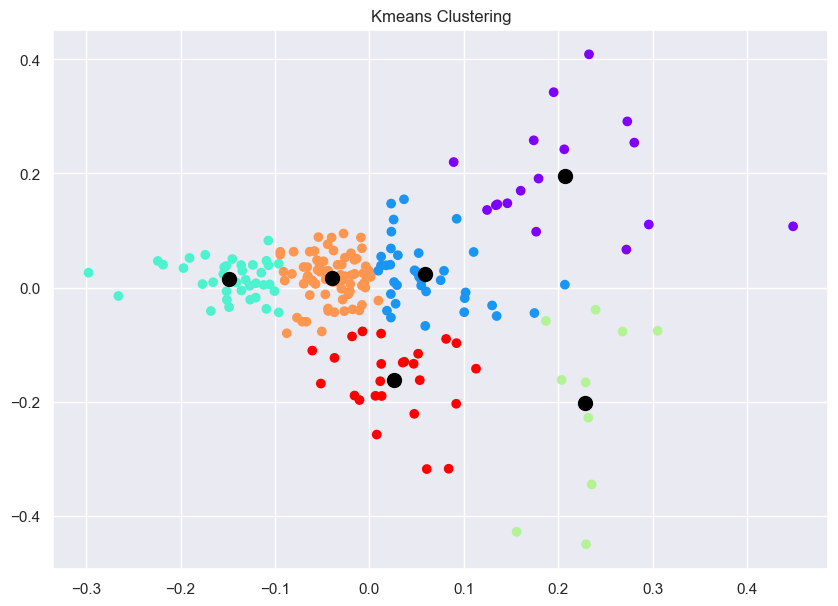

In [41]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='centroid')
plt.title('Kmeans Clustering')

## Checking the quality of the cluster of kmeans with the help of silhouette score

In [42]:
silhouette_score_kmeans = silhouette_score(X, kmeans_labels)

In [43]:
silhouette_score_kmeans

np.float64(0.35813141620219185)

## Implementing Agglomerative Hierarical Clustering Algorithm and finding the optimal number of clusters for agglomerative hierarical clustering algorithm

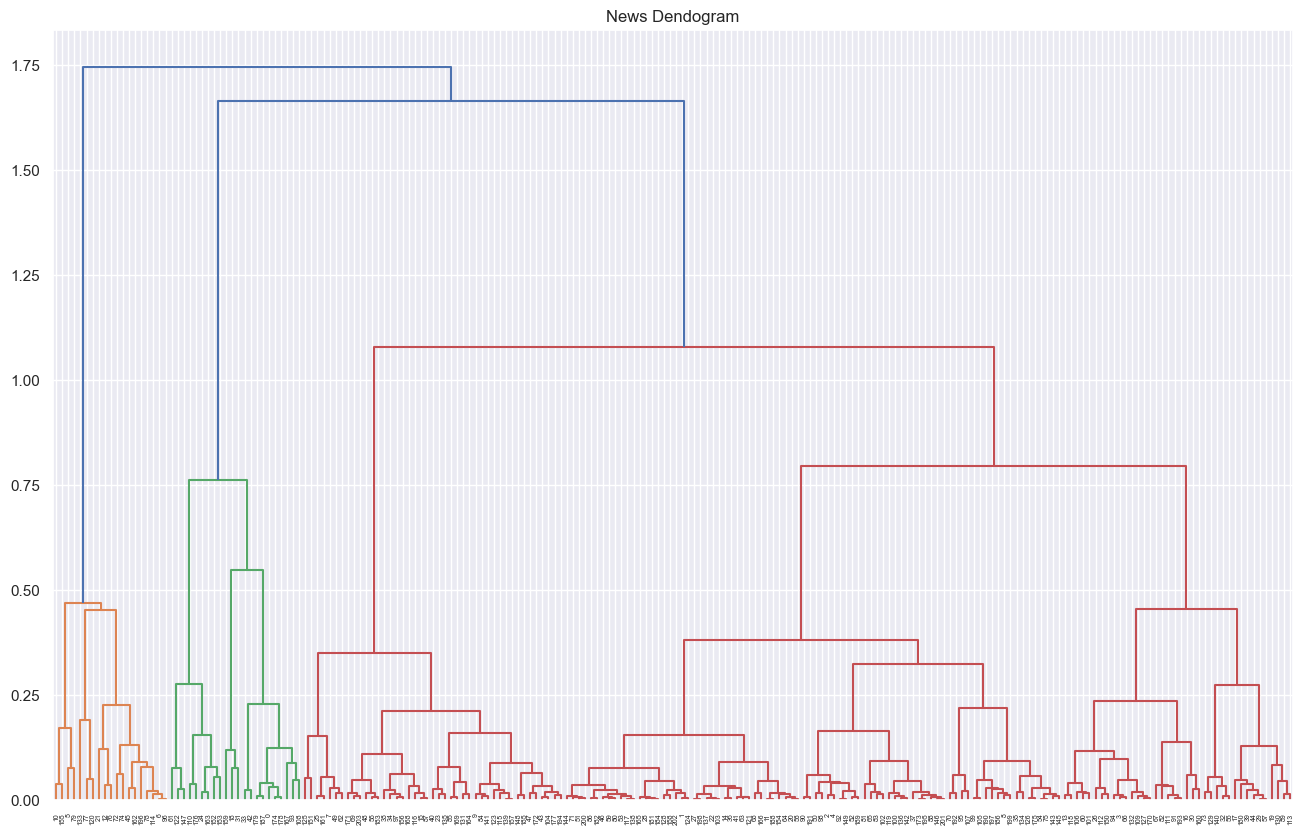

In [45]:
plt.figure(figsize=(16, 10))

plt.title('News Dendogram')

dend = shc.dendrogram(shc.linkage(X, method='ward'))

### By cutting the dendrogram horizontally along the longest line, we get 3 clusters, indicating that the optimal number of clusters for agglomerative clustering is 3.

## Training the model with the optimal number of clusters found from the dendogram

In [47]:
cluster_hierarcial = AgglomerativeClustering(n_clusters=3, linkage='ward')

In [48]:
cluster_hierarcial.fit_predict(X)

array([2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2,
       0, 1, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0])

In [49]:
hiearachy_labels = cluster_hierarcial.labels_

## Plotting the clusters as a scatter plot

Text(0.5, 1.0, 'Agglomerative Hierarical Clustering')

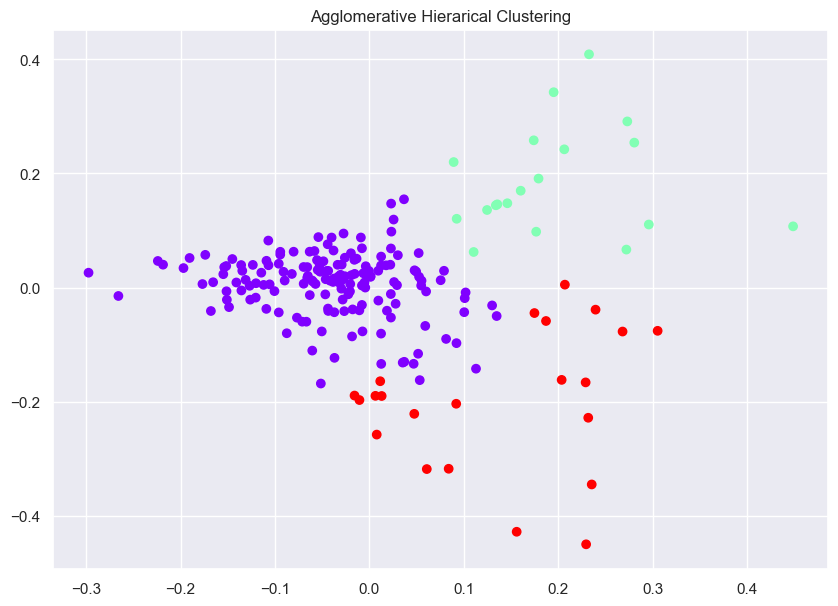

In [50]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=hiearachy_labels, cmap='rainbow')
plt.title('Agglomerative Hierarical Clustering')

## Checking the quality of the cluster of agglomerative hierarical with the help of silhouette score

In [51]:
silhouette_score_hierarchy = silhouette_score(X, hiearachy_labels)

In [52]:
silhouette_score_hierarchy

np.float64(0.5236998723248719)

## Creating a table of the silhouette score of the three algorithm for better comparison

In [55]:
silhoutte_score_df = pd.DataFrame({
    'Algorithm': ['k-means Clustering',  'Agglomerative Hierarical Clustering'],
    'Silhouette Score': [silhouette_score_kmeans, silhouette_score_hierarchy]
})

In [56]:
silhoutte_score_df

,Algorithm,Silhouette Score
0,k-means Clustering,0.358131
1,Agglomerative Hierarical Clustering,0.523700


Text(0.5, 1.0, 'Silhouette Score of each Algorithm')

<Figure size 1200x800 with 0 Axes>

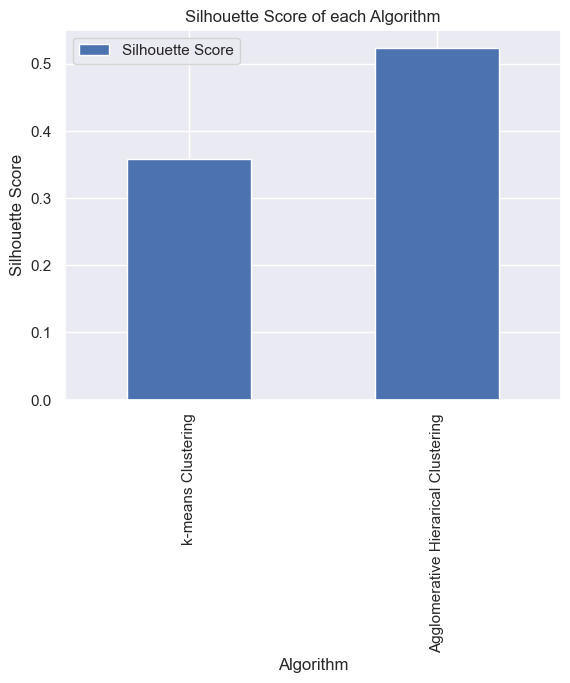

In [57]:
plt.figure(figsize=(12, 8))

silhoutte_score_df.plot(kind='bar', x='Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score of each Algorithm')

## Conclusion

From the table and the graph, it is clear that the silhouette score of Agglomerative Hierarical Clustering is highest among the three indicating that it is the best clustering algorithm for our use case.

Therefore, for this project, THE OPTIMAL NUMBER OF CLUSTERS IS 3.

## Testing the model with sample data

### Creating some sample data

In [58]:
sample_data_true = 'The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.'
sample_data_false = 'Health care reform legislation is likely to mandate free sex change surgeries.'
sample_data_half_true = 'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'
sample_data_mostly_true = 'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."'
sample_data_barely_true = 'Jim Dunnam has not lived in the district he represents for years now.'
sample_data_pants_fire = 'In the case of a catastrophic event, the Atlanta-area offices of the Centers for Disease Control and Prevention will self-destruct.'

### Pre-processing the sample datas

In [59]:
sample_data_true_preproccessed = preprocess_text(sample_data_true)
sample_data_false_preproccessed = preprocess_text(sample_data_false)
sample_data_half_true_preproccessed = preprocess_text(sample_data_half_true)
sample_data_mostly_true_preproccessed = preprocess_text(sample_data_mostly_true)
sample_data_barely_true_preproccessed = preprocess_text(sample_data_barely_true)
sample_data_pants_fire_preproccessed = preprocess_text(sample_data_pants_fire)

### Vectorizing the sample datas

In [60]:
sample_data_true_vectorized = vectorizer.transform([sample_data_true_preproccessed]).toarray()
sample_data_false_vectorized = vectorizer.transform([sample_data_false_preproccessed]).toarray()
sample_data_half_true_vectorized = vectorizer.transform([sample_data_half_true_preproccessed]).toarray()
sample_data_mostly_true_vectorized = vectorizer.transform([sample_data_mostly_true_preproccessed]).toarray()
sample_data_barely_true_vectorized = vectorizer.transform([sample_data_barely_true_preproccessed]).toarray()
sample_data_pants_fire_vectorized = vectorizer.transform([sample_data_pants_fire_preproccessed]).toarray()

### Applying PCA on the sample datas

In [61]:
sample_data_true_pca = pca.transform(sample_data_barely_true_vectorized)
sample_data_false_pca = pca.transform(sample_data_false_vectorized)
sample_data_half_true_pca = pca.transform(sample_data_half_true_vectorized)
sample_data_mostly_true_pca = pca.transform(sample_data_mostly_true_vectorized)
sample_data_barely_true_pca = pca.transform(sample_data_barely_true_vectorized)
sample_data_pants_fire_pca = pca.transform(sample_data_pants_fire_vectorized)

### Using K-Means Algorithm to make prediction on SIngle Input

In [62]:
kmeans = KMeans(n_clusters = 3, init='k-means++', random_state=42)

In [63]:
kmeans.fit_predict(X)

array([1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 2, 0,
       2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 1,
       2, 0, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2], dtype=int32)

In [64]:
pred_single_data = kmeans.predict(sample_data_false_pca)

In [65]:
pred_single_data[0]

np.int32(2)

#### Here, 2 means the above news belongs to cluster number 2

### Using Agglomerative Clustering to make prediction on Multiple Input(three only)

In [66]:
input_data_one = 'The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.' 
input_data_two = 'Jim Dunnam has not lived in the district he represents for years now.'
input_data_three = 'Health care reform legislation is likely to mandate free sex change surgeries.'

#### NOTE: We can't take more than 3 inputs in the array because the number of clusters used to train the agglomerative clustering model is 3.

In [67]:
input_data_one_preproccessed = preprocess_text(input_data_one)
input_data_two_preproccessed = preprocess_text(input_data_two)
input_data_three_preproccessed = preprocess_text(input_data_three)

In [68]:
input_data_final = [input_data_one_preproccessed, input_data_two_preproccessed, input_data_three_preproccessed]

In [69]:
multiple_input_data_vectorized = vectorizer.transform(input_data_final).toarray()

In [70]:
multiple_input_data_pca = pca.transform(multiple_input_data_vectorized)

In [71]:
pred_multiple_data = cluster_hierarcial.fit_predict(multiple_input_data_pca)

In [72]:
pred_multiple_data

array([2, 1, 0])

#### Here, [2, 1, 0] means the first news belongs to cluster number 2, the second news belongs to cluster number 1 and the third news belongs to cluster number 0.

## Generating pickle file of both the models, the pca and the vectorizer

In [73]:
pickle.dump(kmeans, open('modelkmeans.pkl', 'wb'))
pickle.dump(cluster_hierarcial, open('modelhierarchy.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(pca, open('pca.pkl', 'wb'))